In [ ]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

### Vegetable Dataset

From vegetable production to delivery, several common steps are operated manually like picking, and sorting vegetables. The initial experiment is done with 15 types of common vegetables that are found throughout the world. The vegetables that are chosen for the experimentation are- bean, bitter gourd, bottle gourd, brinjal, broccoli, cabbage, capsicum, carrot, cauliflower, cucumber, papaya, potato, pumpkin, radish and tomato. A total of 21000 images from 15 classes are used where each class contains 1400 images of size 224×224 and in *.jpg format. The dataset split 70% for training, 15% for validation, and 15% for testing purpose.

https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

### Download and unzip the dataset

In [ ]:
# train_set
!gdown https://drive.google.com/uc?id=1makfQYVHk5WS1MznDCnbYqwfDap2kVpY

# val_set
!gdown https://drive.google.com/uc?id=1TJa3_Exb1mUZzUvrDYsBzL1zzwJYywNP

# test_set
!gdown https://drive.google.com/uc?id=1e7TWjB5LOfihCwhV5jvLgxE85M43zTlH

Downloading...
From: https://drive.google.com/uc?id=1makfQYVHk5WS1MznDCnbYqwfDap2kVpY
To: /content/vegetable_train.zip
100% 399M/399M [00:03<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TJa3_Exb1mUZzUvrDYsBzL1zzwJYywNP
To: /content/vegetable_test.zip
100% 80.3M/80.3M [00:00<00:00, 81.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e7TWjB5LOfihCwhV5jvLgxE85M43zTlH
To: /content/vegetable_validation.zip
100% 79.6M/79.6M [00:00<00:00, 88.9MB/s]


In [ ]:
%%capture
!unzip /content/vegetable_train.zip;
!unzip /content/vegetable_validation.zip;
!unzip /content/vegetable_test.zip;

### Loading the train, val and test sets from their respective folders

Initializing ImageFolder Instances

initialize train_set

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((90,90))])

train_data_path = '/content/vegetable_train'

train_set = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)

initialize val_set

In [ ]:
val_data_path = '/content/vegetable_validation'

val_set = torchvision.datasets.ImageFolder(root=val_data_path, transform=transform)

initialize test_set

In [ ]:
test_data_path = '/content/vegetable_test'

test_set = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)

### Attributes of the dataset object

In [ ]:
len(dataset)

15000

In [ ]:
dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
dataset.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
dataset.transform

Compose(
    ToTensor()
    Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
)

In [ ]:
class_counts = np.zeros(len(dataset.class_to_idx))

In [ ]:
for image, label in dataset:
    class_counts[label] += 1

In [ ]:
for i in range(len(class_counts)):
  print("class:%s, instances: %d"%([k for k,v in dataset.class_to_idx.items() if v == i], class_counts[i]))

class:['buildings'], instances: 2628
class:['forest'], instances: 2745
class:['glacier'], instances: 2957
class:['mountain'], instances: 3037
class:['sea'], instances: 2784
class:['street'], instances: 2883


### Compute Normalization parameters and apply them to train, val and test sets

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

# Source:
# https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c
# https://en.wikipedia.org/wiki/Standard_deviation

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((90,90))])
dataset = torchvision.datasets.ImageFolder(root='/content/vegetable_train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32)

In [ ]:
mean, std = get_mean_and_std(dataloader)

In [ ]:
mean, std

(tensor([0.4689, 0.4635, 0.3433]), tensor([0.2327, 0.2274, 0.2420]))

In [ ]:
train_set.transform

Compose(
    ToTensor()
    Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
)

In [ ]:
# Define the transform to normalize the dataset
normalize = torchvision.transforms.Normalize(mean=mean, std=std)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((90,90)), normalize])

# Apply the normalization transform to the dataset
train_set.transform = transform
val_set.transform = transform
test_set.transform = transform

In [ ]:
train_set.transform

Compose(
    ToTensor()
    Resize(size=(90, 90), interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=tensor([0.4689, 0.4635, 0.3433]), std=tensor([0.2327, 0.2274, 0.2420]))
)

### Initializing the pytorch dataloaders

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=32,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=True
)


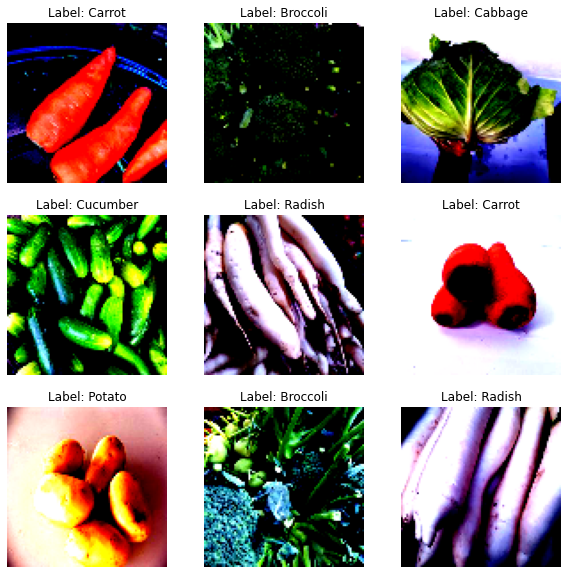

In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(train_loader))

rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)                          )
plt.figure(figsize = (10,10))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {train_set.classes[label]}')

# Convolutional Neural Networks

## nn.Module method of constructing models 

In [ ]:
class Net(torch.nn.Module):   
    def __init__(self, num_of_classes):
        super(Net, self).__init__()

        # Defining a 2D convolution layer
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1)
        self.bn1 = BatchNorm2d(4)
        self.relu1 = ReLU(inplace=True)
        self.maxpool1 = MaxPool2d(kernel_size=2, stride=2)
        
        # Defining another 2D convolution layer
        self.conv2 = Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.bn2 = BatchNorm2d(8)
        self.relu2 = ReLU(inplace=True)
        self.maxpool2 = MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.bn3 = BatchNorm2d(16)
        self.relu3 = ReLU(inplace=True)
        self.maxpool3 = MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn4 = BatchNorm2d(32)
        self.relu4 = ReLU(inplace=True)
        self.maxpool4 = MaxPool2d(kernel_size=2, stride=2)
        
        self.linear_layers = Linear(32 * 5 * 5, num_of_classes)

    # Defining the forward pass    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # Apply conv2, bn2, relu2 and maxpool2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Apply conv3, bn3, relu3 and maxpool3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # Apply conv4, bn4, relu4 and maxpool4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        
        # Flatten the output from the conv layers
        x = x.view(x.size(0), -1)
        
        # Apply the linear layer
        x = self.linear_layers(x)
        return x

In [ ]:
# Initialize the model
model = Net(num_of_classes = 15) 
model.to(device)

## sequential method of constructing models 

In [ ]:
num_of_classes = 15

In [ ]:
model = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            Linear(32 * 5 * 5, num_of_classes)
        )

model.to(device);

# Visualization of Model

### Visualize through torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
dummy_model = Net().to(device)
summary(dummy_model, (3, 90, 90))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 90, 90]             112
       BatchNorm2d-2            [-1, 4, 90, 90]               8
              ReLU-3            [-1, 4, 90, 90]               0
         MaxPool2d-4            [-1, 4, 45, 45]               0
            Conv2d-5            [-1, 8, 45, 45]             296
       BatchNorm2d-6            [-1, 8, 45, 45]              16
              ReLU-7            [-1, 8, 45, 45]               0
         MaxPool2d-8            [-1, 8, 22, 22]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
           Conv2d-13           [-1, 32, 11, 11]           4,640
      BatchNorm2d-14           [-1, 32,

### Visualize through TorchViz

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=a1f0d36612b45ed2c691064c0860bb72daf5423fae6c8bc7db18d8e231e32f17
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [ ]:
from torchviz import make_dot
dummy_image = next(iter(train_loader))[0]
dummy_model = Net()
y_hat = dummy_model(dummy_image)

In [ ]:
make_dot(y_hat.mean(),params=dict(dummy_model.named_parameters())).render("graph2", format="png")

'graph2.png'

In [ ]:
dummy_model.state_dict()

# Model Configuration

In [ ]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop

Variable Initialization

In [ ]:
def run_1_epoch(model, loss_fn, optimizer, loader, train = False):
  
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  # Number of images we can get by the loader
  total_samples_in_loader = len(train_loader.dataset.imgs)
  
  # number of batches we can get by the loader 
  total_batches_in_loader = len(loader)
  
  

  for image_batch, labels in tqdm(loader):
    
    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    # Zeroing out the gradients for parameters
    if train:
      optimizer.zero_grad()
    
    # Forward pass on the input batch
    output = model.forward(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)
    
    # Backpropagation
    if train:
      loss.backward()
    
    # Update the parameters using the gradients
    if train:
      optimizer.step()
    
    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy 

In [ ]:
epochs = 40

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []

val_accuracy_max = -1

In [ ]:
# Main training and validation loop for n number of epochs
for i in range(epochs):

  # Train model for one epoch
  print("Epoch %d: Train"%(i))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, optimizer, train_loader, train= True)

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(i))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, optimizer, val_loader, train= False)
  
  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New Max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))
    torch.save(model,'best_val_acc_model.pth')
  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))


Epoch 0: Train


100%|██████████| 469/469 [01:17<00:00,  6.06it/s]


Epoch 0: Validation


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


train loss: 1.0143
val loss: 0.5192
train_accuracy 68.49
val_accuracy 84.38
New Max val Accuracy Acheived 84.38. Saving model.


Epoch 1: Train


100%|██████████| 469/469 [01:13<00:00,  6.38it/s]


Epoch 1: Validation


100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


train loss: 0.4450
val loss: 0.3372
train_accuracy 86.03
val_accuracy 90.19
New Max val Accuracy Acheived 90.19. Saving model.


Epoch 2: Train


100%|██████████| 469/469 [01:14<00:00,  6.25it/s]


Epoch 2: Validation


100%|██████████| 469/469 [00:56<00:00,  8.23it/s]


train loss: 0.3005
val loss: 0.1887
train_accuracy 91.06
val_accuracy 94.94
New Max val Accuracy Acheived 94.94. Saving model.


Epoch 3: Train


100%|██████████| 469/469 [01:13<00:00,  6.41it/s]


Epoch 3: Validation


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


train loss: 0.2439
val loss: 0.1694
train_accuracy 92.50
val_accuracy 95.27
New Max val Accuracy Acheived 95.27. Saving model.


Epoch 4: Train


100%|██████████| 469/469 [01:13<00:00,  6.40it/s]


Epoch 4: Validation


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


train loss: 0.1944
val loss: 0.1078
train_accuracy 94.17
val_accuracy 97.12
New Max val Accuracy Acheived 97.12. Saving model.


Epoch 5: Train


100%|██████████| 469/469 [01:15<00:00,  6.20it/s]


Epoch 5: Validation


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


train loss: 0.1575
val loss: 0.0932
train_accuracy 95.29
val_accuracy 97.49
New Max val Accuracy Acheived 97.49. Saving model.


Epoch 6: Train


100%|██████████| 469/469 [01:15<00:00,  6.24it/s]


Epoch 6: Validation


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


train loss: 0.1338
val loss: 0.0850
train_accuracy 95.89
val_accuracy 97.61
New Max val Accuracy Acheived 97.61. Saving model.


Epoch 7: Train


100%|██████████| 469/469 [01:12<00:00,  6.43it/s]


Epoch 7: Validation


100%|██████████| 469/469 [00:56<00:00,  8.36it/s]


train loss: 0.1215
val loss: 0.0882
train_accuracy 96.18
val_accuracy 97.50
val accuracy did not increase from 97.61


Epoch 8: Train


100%|██████████| 469/469 [01:14<00:00,  6.27it/s]


Epoch 8: Validation


100%|██████████| 469/469 [00:54<00:00,  8.66it/s]


train loss: 0.1001
val loss: 0.0576
train_accuracy 97.08
val_accuracy 98.61
New Max val Accuracy Acheived 98.61. Saving model.


Epoch 9: Train


100%|██████████| 469/469 [01:14<00:00,  6.30it/s]


Epoch 9: Validation


100%|██████████| 469/469 [00:55<00:00,  8.51it/s]


train loss: 0.0899
val loss: 0.0532
train_accuracy 97.33
val_accuracy 98.56
val accuracy did not increase from 98.61


Epoch 10: Train


100%|██████████| 469/469 [01:13<00:00,  6.39it/s]


Epoch 10: Validation


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


train loss: 0.0835
val loss: 0.1360
train_accuracy 97.34
val_accuracy 94.91
val accuracy did not increase from 98.61


Epoch 11: Train


100%|██████████| 469/469 [01:12<00:00,  6.48it/s]


Epoch 11: Validation


100%|██████████| 469/469 [00:54<00:00,  8.60it/s]


train loss: 0.0723
val loss: 0.0415
train_accuracy 97.83
val_accuracy 98.93
New Max val Accuracy Acheived 98.93. Saving model.


Epoch 12: Train


100%|██████████| 469/469 [01:13<00:00,  6.37it/s]


Epoch 12: Validation


100%|██████████| 469/469 [00:53<00:00,  8.72it/s]


train loss: 0.0719
val loss: 0.0497
train_accuracy 97.65
val_accuracy 98.61
val accuracy did not increase from 98.93


Epoch 13: Train


100%|██████████| 469/469 [01:13<00:00,  6.38it/s]


Epoch 13: Validation


100%|██████████| 469/469 [00:53<00:00,  8.76it/s]


train loss: 0.0678
val loss: 0.0285
train_accuracy 97.95
val_accuracy 99.31
New Max val Accuracy Acheived 99.31. Saving model.


Epoch 14: Train


100%|██████████| 469/469 [01:13<00:00,  6.37it/s]


Epoch 14: Validation


100%|██████████| 469/469 [00:55<00:00,  8.50it/s]


train loss: 0.0545
val loss: 0.0369
train_accuracy 98.25
val_accuracy 98.87
val accuracy did not increase from 99.31


Epoch 15: Train


100%|██████████| 469/469 [01:12<00:00,  6.51it/s]


Epoch 15: Validation


100%|██████████| 469/469 [00:53<00:00,  8.73it/s]


train loss: 0.0555
val loss: 0.0292
train_accuracy 98.25
val_accuracy 99.25
val accuracy did not increase from 99.31


Epoch 16: Train


100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Epoch 16: Validation


100%|██████████| 469/469 [00:54<00:00,  8.58it/s]


train loss: 0.0454
val loss: 0.0407
train_accuracy 98.55
val_accuracy 98.77
val accuracy did not increase from 99.31


Epoch 17: Train


100%|██████████| 469/469 [01:09<00:00,  6.71it/s]


Epoch 17: Validation


100%|██████████| 469/469 [00:53<00:00,  8.78it/s]


train loss: 0.0606
val loss: 0.0507
train_accuracy 98.05
val_accuracy 98.26
val accuracy did not increase from 99.31


Epoch 18: Train


100%|██████████| 469/469 [01:10<00:00,  6.70it/s]


Epoch 18: Validation


100%|██████████| 469/469 [00:53<00:00,  8.80it/s]


train loss: 0.0432
val loss: 0.0370
train_accuracy 98.65
val_accuracy 98.81
val accuracy did not increase from 99.31


Epoch 19: Train


100%|██████████| 469/469 [01:10<00:00,  6.68it/s]


Epoch 19: Validation


100%|██████████| 469/469 [00:54<00:00,  8.60it/s]


train loss: 0.0425
val loss: 0.0343
train_accuracy 98.55
val_accuracy 98.92
val accuracy did not increase from 99.31


Epoch 20: Train


100%|██████████| 469/469 [01:10<00:00,  6.69it/s]


Epoch 20: Validation


100%|██████████| 469/469 [00:53<00:00,  8.82it/s]


train loss: 0.0412
val loss: 0.0489
train_accuracy 98.65
val_accuracy 98.37
val accuracy did not increase from 99.31


Epoch 21: Train


100%|██████████| 469/469 [01:09<00:00,  6.71it/s]


Epoch 21: Validation


100%|██████████| 469/469 [00:53<00:00,  8.79it/s]


train loss: 0.0461
val loss: 0.0171
train_accuracy 98.51
val_accuracy 99.57
New Max val Accuracy Acheived 99.57. Saving model.


Epoch 22: Train


100%|██████████| 469/469 [01:10<00:00,  6.64it/s]


Epoch 22: Validation


100%|██████████| 469/469 [00:52<00:00,  8.90it/s]


train loss: 0.0332
val loss: 0.0227
train_accuracy 98.87
val_accuracy 99.33
val accuracy did not increase from 99.57


Epoch 23: Train


100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Epoch 23: Validation


100%|██████████| 469/469 [00:53<00:00,  8.71it/s]


train loss: 0.0461
val loss: 0.0354
train_accuracy 98.57
val_accuracy 98.96
val accuracy did not increase from 99.57


Epoch 24: Train


100%|██████████| 469/469 [01:10<00:00,  6.69it/s]


Epoch 24: Validation


100%|██████████| 469/469 [00:53<00:00,  8.70it/s]


train loss: 0.0313
val loss: 0.0129
train_accuracy 99.05
val_accuracy 99.69
New Max val Accuracy Acheived 99.69. Saving model.


Epoch 25: Train


100%|██████████| 469/469 [01:10<00:00,  6.65it/s]


Epoch 25: Validation


100%|██████████| 469/469 [00:52<00:00,  8.91it/s]


train loss: 0.0238
val loss: 0.0083
train_accuracy 99.29
val_accuracy 99.81
New Max val Accuracy Acheived 99.81. Saving model.


Epoch 26: Train


100%|██████████| 469/469 [01:10<00:00,  6.64it/s]


Epoch 26: Validation


100%|██████████| 469/469 [00:53<00:00,  8.70it/s]


train loss: 0.0233
val loss: 0.0236
train_accuracy 99.27
val_accuracy 99.35
val accuracy did not increase from 99.81


Epoch 27: Train


100%|██████████| 469/469 [01:09<00:00,  6.71it/s]


Epoch 27: Validation


100%|██████████| 469/469 [00:53<00:00,  8.77it/s]


train loss: 0.0367
val loss: 0.0155
train_accuracy 98.84
val_accuracy 99.55
val accuracy did not increase from 99.81


Epoch 28: Train


100%|██████████| 469/469 [01:09<00:00,  6.71it/s]


Epoch 28: Validation


100%|██████████| 469/469 [00:53<00:00,  8.77it/s]


train loss: 0.0306
val loss: 0.0107
train_accuracy 98.99
val_accuracy 99.77
val accuracy did not increase from 99.81


Epoch 29: Train


100%|██████████| 469/469 [01:09<00:00,  6.71it/s]


Epoch 29: Validation


100%|██████████| 469/469 [00:53<00:00,  8.76it/s]


train loss: 0.0244
val loss: 0.0122
train_accuracy 99.29
val_accuracy 99.70
val accuracy did not increase from 99.81


Epoch 30: Train


100%|██████████| 469/469 [01:09<00:00,  6.74it/s]


Epoch 30: Validation


100%|██████████| 469/469 [00:54<00:00,  8.67it/s]


train loss: 0.0293
val loss: 0.0131
train_accuracy 99.09
val_accuracy 99.63
val accuracy did not increase from 99.81


Epoch 31: Train


100%|██████████| 469/469 [01:11<00:00,  6.57it/s]


Epoch 31: Validation


100%|██████████| 469/469 [00:53<00:00,  8.82it/s]


train loss: 0.0428
val loss: 0.0157
train_accuracy 98.61
val_accuracy 99.55
val accuracy did not increase from 99.81


Epoch 32: Train


100%|██████████| 469/469 [01:09<00:00,  6.70it/s]


Epoch 32: Validation


100%|██████████| 469/469 [00:52<00:00,  8.93it/s]


train loss: 0.0288
val loss: 0.0057
train_accuracy 99.02
val_accuracy 99.85
New Max val Accuracy Acheived 99.85. Saving model.


Epoch 33: Train


100%|██████████| 469/469 [01:09<00:00,  6.73it/s]


Epoch 33: Validation


100%|██████████| 469/469 [00:53<00:00,  8.72it/s]


train loss: 0.0148
val loss: 0.0033
train_accuracy 99.65
val_accuracy 99.99
New Max val Accuracy Acheived 99.99. Saving model.


Epoch 34: Train


100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Epoch 34: Validation


100%|██████████| 469/469 [00:52<00:00,  8.90it/s]


train loss: 0.0235
val loss: 0.0165
train_accuracy 99.23
val_accuracy 99.46
val accuracy did not increase from 99.99


Epoch 35: Train


100%|██████████| 469/469 [01:11<00:00,  6.58it/s]


Epoch 35: Validation


100%|██████████| 469/469 [00:54<00:00,  8.55it/s]


train loss: 0.0256
val loss: 0.0093
train_accuracy 99.11
val_accuracy 99.75
val accuracy did not increase from 99.99


Epoch 36: Train


100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Epoch 36: Validation


100%|██████████| 469/469 [00:54<00:00,  8.62it/s]


train loss: 0.0194
val loss: 0.0122
train_accuracy 99.37
val_accuracy 99.63
val accuracy did not increase from 99.99


Epoch 37: Train


100%|██████████| 469/469 [01:09<00:00,  6.72it/s]


Epoch 37: Validation


100%|██████████| 469/469 [00:52<00:00,  8.86it/s]


train loss: 0.0210
val loss: 0.0063
train_accuracy 99.33
val_accuracy 99.83
val accuracy did not increase from 99.99


Epoch 38: Train


100%|██████████| 469/469 [01:10<00:00,  6.68it/s]


Epoch 38: Validation


100%|██████████| 469/469 [00:53<00:00,  8.78it/s]


train loss: 0.0286
val loss: 0.0039
train_accuracy 99.10
val_accuracy 99.95
val accuracy did not increase from 99.99


Epoch 39: Train


100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Epoch 39: Validation


100%|██████████| 469/469 [00:52<00:00,  8.93it/s]

train loss: 0.0242
val loss: 0.0054
train_accuracy 99.17
val_accuracy 99.88
val accuracy did not increase from 99.99




In [ ]:
!cp /content/veg_2_norm.pth /content/drive/MyDrive/Machvis/Labs/trained_models

**Accuracy and Loss Result Graphs:**

Text(0.5, 1.0, 'Training and val Loss')

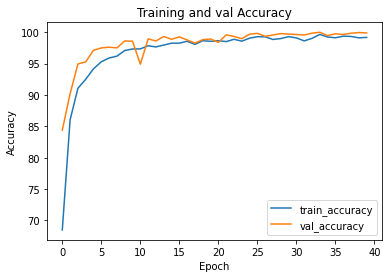

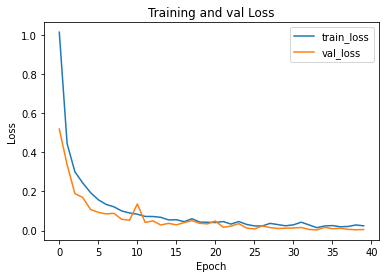

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

# Evaluating the Model

**Loading the best saved model:**

In [ ]:
best_val_model1 = torch.load('/content/veg_2_norm.pth')

In [ ]:
with torch.no_grad():
    test_loss, test_accuracy  = run_1_epoch(best_val_model1, loss_function, optimizer, test_loader, train= False)

print('test loss: %.4f'%(train_loss))
print('test_accuracy %.2f' % (train_accuracy))


100%|██████████| 94/94 [00:10<00:00,  8.71it/s]

test loss: 0.0242
test_accuracy 99.17


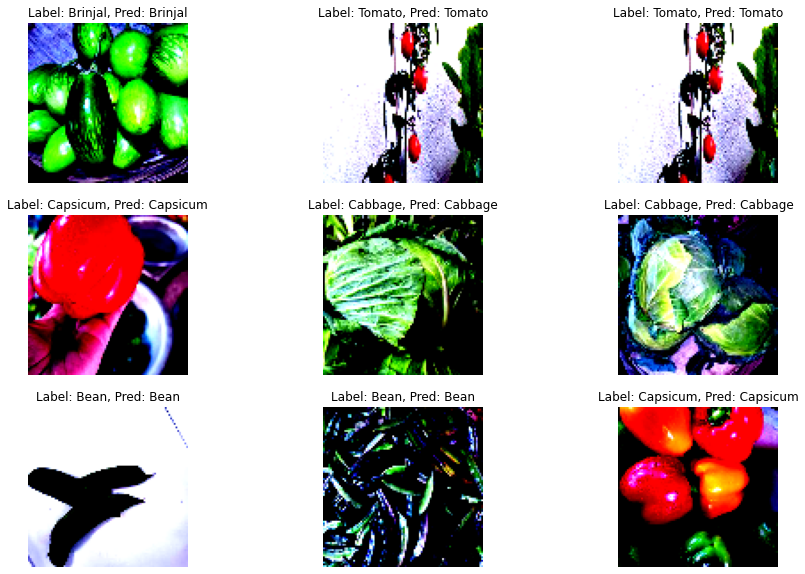

In [ ]:
# Get a batch of images from the train_loader
images, labels = next(iter(test_loader))

with torch.no_grad():
  predicted_labels = model(images.to(device))
  predicted_labels = torch.argmax(predicted_labels, 1)
rows = col = 3
#fig, axes = plt.subplots(nrows=5, ncols=5)                          )
plt.figure(figsize = (10,20))

for i in range(rows*col):
  # Plot a random image from the batch
  random_index = np.random.randint(0, images.shape[0])
  image = images[random_index]
  label = labels[random_index]
  pred_label = predicted_labels[random_index]
  plt.subplot(rows, col, i+1)
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))
  plt.title(f'Label: {test_set.classes[label]}, Pred: {test_set.classes[pred_label]}')

# Credits
Notebook Prepared by Bostan Khan, Team Lead, MachVIS Lab